# Solve the wave equation

In [1]:
function coords(nn, ni, dt, dx)
    t = [n * dt for i in 0:ni, n in 0:nn]
    x = [i * dx for i in 0:ni, n in 0:nn]
    return t, x
end

coords (generic function with 1 method)

In [2]:
nn = 100
ni = 100
dt = 1/(nn)
dx = 1/(ni)
t, x = coords(nn, ni, dt, dx);

In [3]:
using Random
using CairoMakie

# Here are some different initial conditions

In [4]:
function standing(t, x)
    ni, nn = size(t)
    u = zeros(ni, nn)
    # Initial conditions for first two points in time
    for n in 1:2, i in 1:ni
        u[i, n] = cos(2π * t[i, n]) * sin(2π * x[i, n])
#         u[i, n] = exp(2π * t[i, n] * x[i, n])
#         u[i, n] = real(exp(im * 2π * t[i, n] * x[i, n]))
#         u[i, n] = imag(exp(im * 2π * t[i, n] * x[i, n]))
#         p = exp(im * 2π * t[i, n] * x[i, n])
#         u[i, n] = p * conj(p)
#         u[i, n] = real(exp(im * 2π * t[i, n] * x[i, n]))-imag(exp(im * 2π * t[i, n] * x[i, n]))
    end
    return u
end

function delta(t,x)
    ni, nn = size(t)
    u = zeros(ni, nn)
    set = rand(MersenneTwister(0), 1:ni-1, 15)
    # Initial conditions for first two points in time
    for n in 1:2, i in set
        u[i, n] = 5*cos(π/5 * i) #cos(2π * t[n, i]) * sin(2π * x[n, i])
    end
    return u
end

delta (generic function with 1 method)

In [23]:
# u = standing(t, x);
u = delta(t,x);
# u2 = reverseAllx!(u,dt,dx);

# Plot the initial conditions
in this case we generated a bunch of random excitations at t = 0 across the x_i boundary

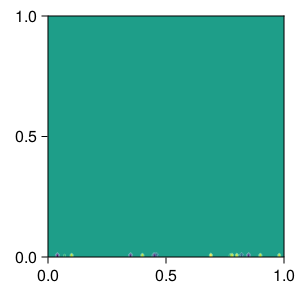

In [24]:
fig = Figure(resolution = (300, 300))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(u))
fig

In [25]:
# fig = Figure(resolution = (300, 300))
# ax = Axis(fig[1, 1])
# contourf!(vec(x), vec(t), vec(u2))
# fig

In [26]:
#find the solution at one interior point
function evolve_point!(u, dt, dx, n, i)
    ni, nn = size(u)
#     finite difference for second derivative in x direction
    uxx = (u[i-1,n-1] - 2*u[i,n-1] + u[i+1,n-1])/dx^2
#     time derivative
#     utt = (u[i,n-2] - 2*u[i,n-1] + u[i,n])/dt^2
#     solve for u[i,n]
#     utt = uxx
    u[i,n] = uxx * dt^2 - u[i,n-2] + 2*u[i,n-1]
    return
end

evolve_point! (generic function with 1 method)

In [27]:
#find the solution at one interior point
function evolve_point_periodic!(u, dt, dx, n, i)
    ni, nn = size(u)
#     finite difference for second derivative in x direction
    if i == 1
        uxx = (u[ni,n-1] - 2*u[i,n-1] + u[i+1,n-1])/dx^2
    elseif i == ni
        uxx = (u[i-1,n-1] - 2*u[i,n-1] + u[1,n-1])/dx^2
    else
        uxx = (u[i-1,n-1] - 2*u[i,n-1] + u[i+1,n-1])/dx^2
    end
#     time derivative
#     utt = (u[i,n-2] - 2*u[i,n-1] + u[i,n])/dt^2
#     solve for u[i,n]
#     utt = uxx
    u[i,n] = uxx * dt^2 - u[i,n-2] + 2*u[i,n-1]
    return
end

evolve_point_periodic! (generic function with 1 method)

In [28]:
# find the solution for one point in time
function evolve_step!(u, dt, dx, n)
    ni, nn = size(u)
    #dirischelet boundary conditon - set to 0
    u[1,n] = 0
    u[ni,n] = 0
    for i in 2:ni-1
        evolve_point!(u, dt, dx, n, i)
    end
    
    return
end


evolve_step! (generic function with 1 method)

In [29]:
# find the solution for one point in time
function evolve_step_periodic!(u, dt, dx, n)
    ni, nn = size(u)
    #dirischelet boundary conditon - set to 0
#     u[1,n] = 0
#     u[ni,n] = 0
    for i in 1:ni
        evolve_point_periodic!(u, dt, dx, n, i)
    end
    
    return
end


evolve_step_periodic! (generic function with 1 method)

In [30]:
# find the solution everywhere
function evolve!(u, dt, dx)
    ni, nn = size(u)
#     loop over all times
    for n in 3:nn
        evolve_step!(u, dt, dx, n)
    end
    return
end

evolve! (generic function with 1 method)

In [31]:
# find the solution everywhere
function evolve_periodic!(u, dt, dx)
    ni, nn = size(u)
#     loop over all times
    for n in 3:nn
        evolve_step_periodic!(u, dt, dx, n)
    end
    return
end

evolve_periodic! (generic function with 1 method)

In [32]:
#swap end point boundary conditions for initial conditions to evolve
#even further through time
function swapBoundary!(u, dt, dx)
    ni, nn = size(u)
    
    for n in 1:3
        for i in 1:ni
            u[i,n] = u[i,nn-3 + n]
        end
    end
    return
end

swapBoundary! (generic function with 1 method)

In [33]:
# swap the boundary conditions in reverse order, to run time backwards in a sense 
# starting from the end boundary conditons to t = 0.
function swapBoundaryRev!(u, dt, dx)
    ni, nn = size(u)
    
    for n in 1:3
        for i in 1:ni
            u[i,n] = u[i,nn-(n-1)]
        end
    end
    return
end

swapBoundaryRev! (generic function with 1 method)

In [34]:
# reverse order of time direction for all slices
function reverseAll!(u, dt, dx)
    ni, nn = size(u)
    nu = zeros(ni,nn)

    for n in 1:nn
        for i in 1:ni
            nu[i,n] = u[i,nn-(n-1)]
        end
    end
    return nu
    # return new matrix of spacetime
end

# reverse order of time direction for all slices
function reverseAllx!(u, dt, dx)
    ni, nn = size(u)
    nu = zeros(ni,nn)

    for i in 1:ni
        for n in 1:nn
            nu[i,n] = u[ni-(i-1),n]
        end
    end
    return nu
    # return new matrix of spacetime
end

reverseAllx! (generic function with 1 method)

Now lets evolve those initial conditions

In [35]:
# swapBoundary!(u, dt, dx)
evolve!(u,dt,dx)
# evolve!(u2,dt,dx)

and see what we get

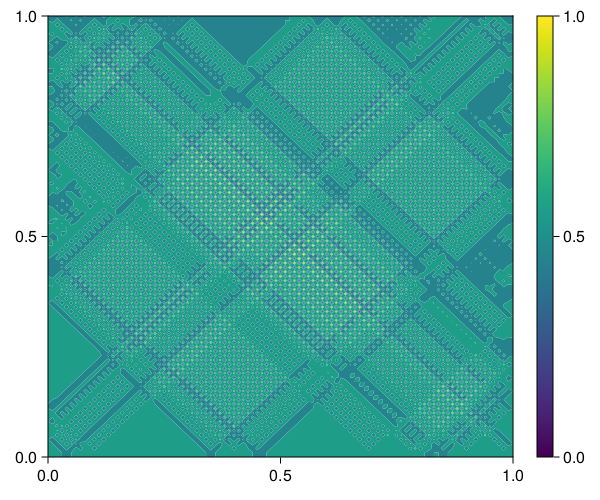

In [36]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(u))
Colorbar(fig[1,2],colormap=:viridis)
fig

Wow! look at those light cones. Now lets reverse the order of time, swapping each time slice about t = maxt/2. Now lets evolve that state. Remember only the first two time slices matter in future calculations of our system, so the other slices above t = 2 get replaced by the calculated future evolution. 

In [37]:
nu = reverseAll!(u, dt, dx);
evolve!(nu,dt,dx)

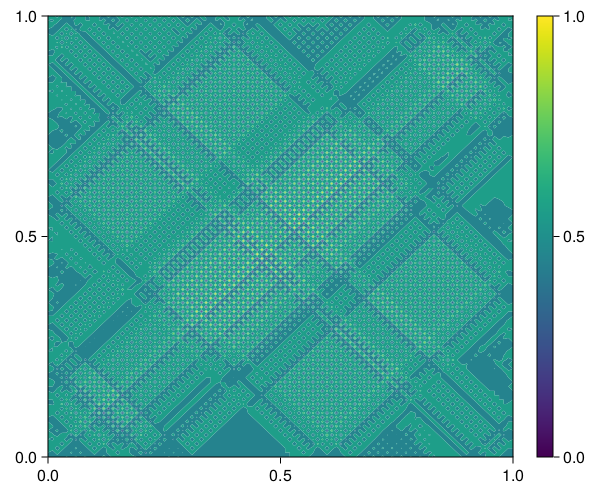

In [38]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(nu))
Colorbar(fig[1,2],colormap=:viridis)
fig

Wow! this looks alot like our origianally evolved system starting from the t = 0 boundary conditons, but flipped around. But hey this system started from the boundary conditions at t = maxt. Lets reverse the order of time once again and see the difference between the two systems starting from inital and final conditions. 

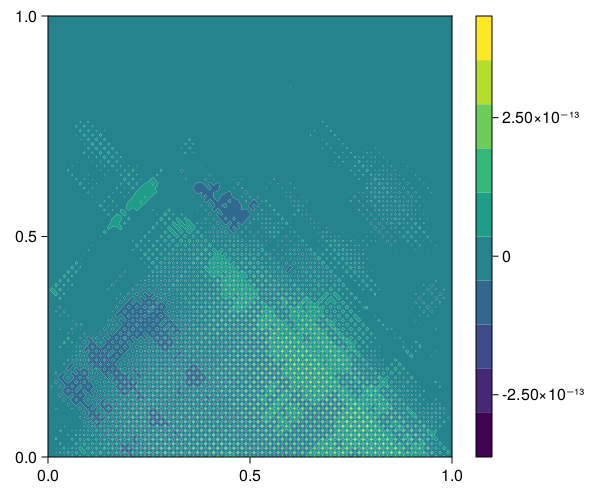

In [39]:
nu = reverseAll!(nu, dt, dx)

fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
co = contourf!(vec(x), vec(t), vec(u.-nu))
Colorbar(fig[1,2],co)
fig

Wow!!! Look at the pattern in that uncertiainty!! We can see that the uncertainty is essentially zero from t = 1 to t = .75!! After this point, the difference between the forward time evolved system and the backwards time evolved system becomes apparent. I believe this is because the lightcone inherent in the system. This means that if we have all the information in the future lightcone at some timeslice we can basically perfectly recreate the previous system. But as we go beyond a point where the lightcone now intersects with the boundary that we threw away information beyond, then we get loss of information beyond that point. What if we made the boundary condtions periodic? Lets see!

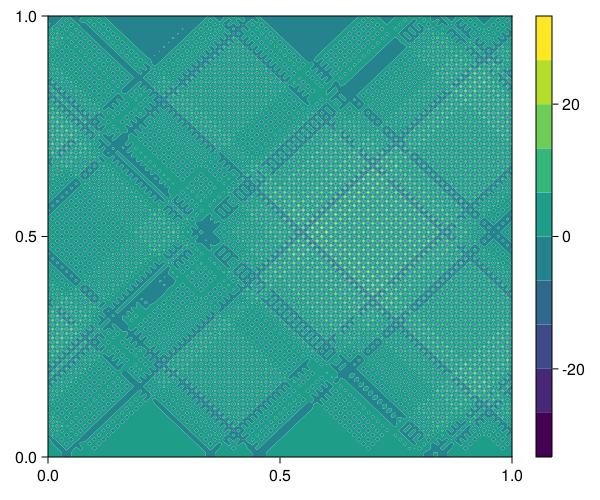

In [40]:
u = delta(t,x);
evolve_periodic!(u,dt,dx)
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
co = contourf!(vec(x), vec(t), vec(u))
Colorbar(fig[1,2],co)
fig

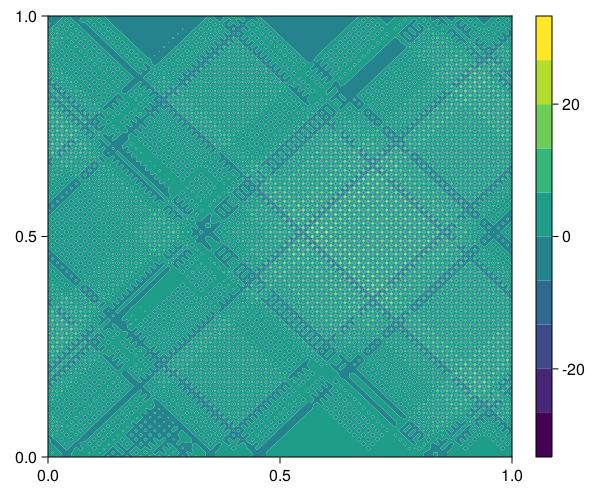

In [41]:
nu = reverseAll!(u, dt, dx)
evolve_periodic!(nu,dt,dx)
nu = reverseAll!(nu, dt, dx)
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
co = contourf!(vec(x), vec(t), vec(nu))
Colorbar(fig[1,2],co)
fig

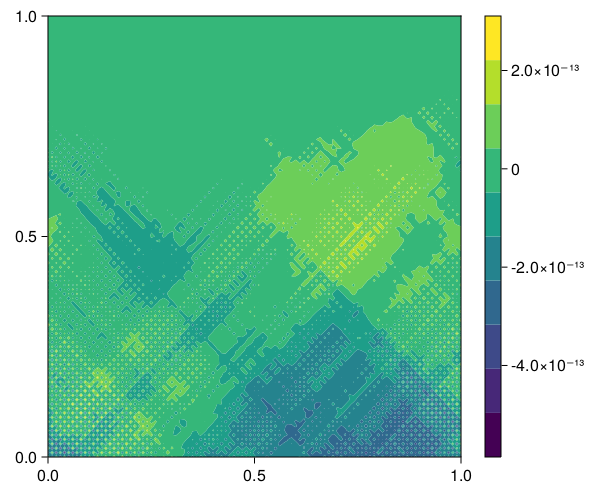

In [42]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
co = contourf!(vec(x), vec(t), vec(u.-nu))
Colorbar(fig[1,2],co)
fig

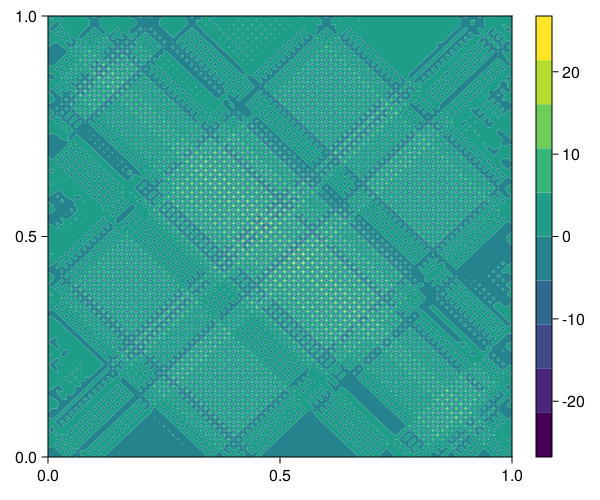

In [43]:
nu = reverseAll!(nu, dt, dx)
evolve!(nu,dt,dx)
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
co = contourf!(vec(x), vec(t), vec(nu))
Colorbar(fig[1,2],co)
fig

In [44]:
swapBoundaryRev!(u, dt, dx)
evolve!(u,dt,dx)

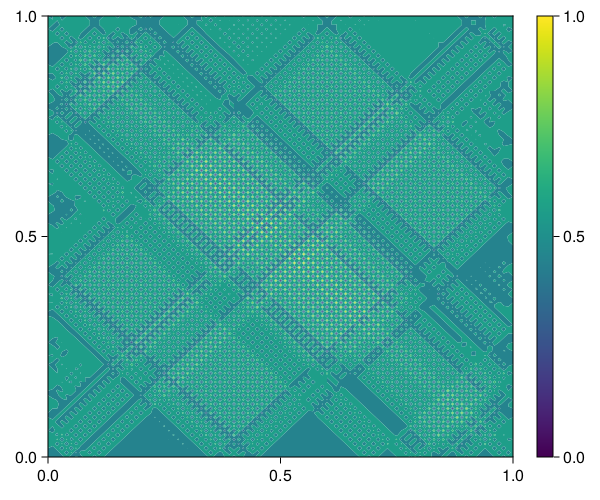

In [45]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1])
contourf!(vec(x), vec(t), vec(u))
Colorbar(fig[1,2],colormap=:viridis)
fig